# Extract thông tin tài chính từ tin tức.

Để đánh giá tình hình tài chính của một công ty, một trong những nguồn thông tin quan trọng là các bài báo, tin tức về công ty đó. Tuy nhiên, việc đọc và tổng hợp thông tin từ các bài báo là một công việc tốn thời gian và công sức. Trong bài toán này, chúng ta sẽ xây dựng một mô hình để tự động trích xuất thông tin tài chính từ các bài báo về công ty.

```
{công ty A} => {có_lợi_nhuận, không_có_lợi_nhuận, lợi_nhuận_tăng, lợi_nhuận_giảm, v.v.} => {tiền_tệ, số_tiền, v.v.}
```

https://neo4j.com/labs/genai-ecosystem/llamaindex/


In [7]:
from dotenv import load_dotenv
import os
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

import nest_asyncio
nest_asyncio.apply()
# Install the python-dotenv package if not already installed
%pip install python-dotenv

# Load the .env file

load_dotenv('../.env')

# Access the OpenAI key
openai_key = os.getenv("OPENAI_API_KEY")

llm = OpenAI(model="gpt-4o-mini", api_key=openai_key)
embed_model = OpenAIEmbedding(model="text-embedding-3-small")

Settings.llm = llm
Settings.embed_model = embed_model

FOLDER_DATA = "../data/bao-chi"

Note: you may need to restart the kernel to use updated packages.


In [8]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core import PropertyGraphIndex
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI

from llama_index.graph_stores.neo4j import Neo4jPropertyGraphStore

documents = SimpleDirectoryReader(FOLDER_DATA).load_data()
print("length of documents:", len(documents))
print('documents:', documents[1])



length of documents: 24
documents: Doc ID: 8155d634-ffa3-4f76-982e-3630f32778bd
Text: Khối ngoại bất ngờ có tuần bán ròng hơn 2.000 tỷ, cổ phiếu “đại
gia” công nghệ số 1 Việt Nam dẫn đầu danh sách xả hàng


In [10]:
from neo4j import GraphDatabase

def truncate_table():
    # Define the connection details
    uri = "bolt://localhost:7687"
    username = "neo4j"
    password = "ttt@123ASD"

    # Create a Neo4j driver instance
    driver = GraphDatabase.driver(uri, auth=(username, password))

    # Function to truncate all data in the database
    def truncate_database(driver):
        with driver.session() as session:
            session.run("MATCH (n) DETACH DELETE n")

    # Truncate the database
    truncate_database(driver)

    # Close the driver connection
    driver.close()

In [9]:
graph_store = Neo4jPropertyGraphStore(
    username="neo4j",
    password="ttt@123ASD",
    url="bolt://localhost:7687",
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


In [11]:
from typing import Literal

entities = Literal[
    "mã_cổ_phiếu", "công_ty", "lợi_nhuận", "giá_cổ_phiếu", "khối_lượng_giao_dịch", "ngày_giao_dịch",
    "tài_sản", "khoản_phải_thu", "dự_án", "doanh_thu", "lợi_nhuận_gộp", "lãi_ròng",
    "lợi_nhuận_sau_thuế", "tồn_kho", "khoản_phải_thu_ngắn_hạn", "bên_liên_quan", "ngành_công_nghiệp"
]

relations = Literal[
    "sở_hữu", "thuộc_về", "là", "là_một_phần_của", "tăng", "giảm", "giao_dịch_vào_ngày",
    "công_bố", "triển_khai", "đạt", "phát_sinh", "trừ", "lên_đến", "chiếm", "hợp_tác", "liên_quan_tới"
]
schema = {
    "mã_cổ_phiếu": ["sở_hữu", "thuộc_về", "là", "thuộc_về_ngành_công_nghiệp"],
    "công_ty": ["sở_hữu", "thuộc_về"],
    "lợi_nhuận": ["tăng", "giảm"],
    "giá_cổ_phiếu": ["tăng", "giảm"],
    "khối_lượng_giao_dịch": ["giao_dịch_vào_ngày"],
    "ngày_giao_dịch": ["giao_dịch_vào_ngày"],
    "tài_sản": ["tăng", "giảm"],
    "khoản_phải_thu": ["tăng", "giảm"],
    "dự_án": ["triển_khai", "thuộc_về"],
    "doanh_thu": ["đạt"],
    "lợi_nhuận_gộp": ["đạt"],
    "lãi_ròng": ["đạt"],
    "lợi_nhuận_sau_thuế": ["đạt"],
    "tồn_kho": ["tăng", "giảm"],
    "khoản_phải_thu_ngắn_hạn": ["tăng", "giảm"],
    "bên_liên_quan": ["hợp_tác"],
    "ngành_công_nghiệp": ["liên_quan_tới"]
}

In [12]:
from llama_index.core.indices.property_graph import SchemaLLMPathExtractor

# truncate_table()

kg_extractor = SchemaLLMPathExtractor(
    llm=OpenAI(model="gpt-4o-mini", temperature=0.0),
    possible_entities=entities,
    possible_relations=relations,
    kg_validation_schema=schema,
    strict=False,  # if false, will allow triplets outside of the schema
    num_workers=2,
    max_triplets_per_chunk=10,
)


# Extract graph from documents
index = PropertyGraphIndex.from_documents(
    documents,
    embed_model=OpenAIEmbedding(model_name="text-embedding-3-small"),
    kg_extractors=[
        kg_extractor
    ],
    show_progress=True,
    property_graph_store=graph_store,
)

/Users/ngocp/Documents/projects/finance-bot/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating embeddings: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL (e, row) { ... }} {position: line: 10, column: 21, offset: 397} for query: "\n                    UNWIND $data AS row\n                    MERGE (e:__Node__ {id: row.id})\n                    SET e += apoc.map.clean(row.properties, [], [])\n                    SET e.name = row.name, e:`__Entity__`\n                    WITH e, row\

In [15]:
# save and load
# index.storage_context.persist(persist_dir="./storage")

from llama_index.core import StorageContext, load_index_from_storage

# index = load_index_from_storage(
#     StorageContext.from_defaults(persist_dir="./storage")
# )

In [17]:

# Define retriever
retriever = index.as_retriever(
    include_text=False,  # include source text in returned nodes, default True
)

question = "CTCP Trung tâm Hội chợ Triển lãm Việt Nam (VEFAC – mã VEF) có lợi nhuận gộp bao nhiêu ?"
results = retriever.retrieve(question)
print("Retrieved nodes:")
for record in results:
    print("record:", record.text)

print("Ask:")
# Question answering
query_engine = index.as_query_engine(include_text=True)
response = query_engine.query(question)
print(str(response))

Retrieved nodes:
record: VEFAC -> LÀ_MỘT_PHẦN_CỦA -> Trung tâm Hội chợ Triển lãm Việt Nam
record: VEFAC -> TRIỂN_KHAI -> Trung tâm Hội chợ Triển lãm Quốc gia
record: Trung tâm Hội chợ Triển lãm Quốc gia -> THUỘC_VỀ -> VEFAC
record: VEFAC -> CÔNG_BỐ -> Trung tâm Hội chợ Triển lãm Quốc gia
record: Trung tâm Hội chợ Triển lãm Quốc gia -> LÀ_MỘT_PHẦN_CỦA -> thương mại dịch vụ
record: Trung tâm Hội chợ Triển lãm Quốc gia -> ĐẠT -> 90ha
record: CTCP Trung tâm Hội chợ Triển lãm Việt Nam -> CÔNG_BỐ -> Gần 800 triệu đồng
record: VEFAC -> TĂNG -> gần 22.000 tỷ đồng
Ask:
Lợi nhuận gộp của CTCP Trung tâm Hội chợ Triển lãm Việt Nam (VEFAC – mã VEF) là gần 800 triệu đồng.


In [18]:
test_pairs = [
    ("lãi sau thuế của Chứng khoán LPBank ?", "Tăng 275% so với cùng kỳ năm trước"),
    ("thu gom cố phiếu MSN?", "Khối ngoại cũng giải ngân mua ròng 179 tỷ tại cổ phiếu MSN"),
    ("Doanh thu Bia Sài Gòn - Quảng Ngãi (BSQ) ?", "Bia Sài Gòn - Quảng Ngãi (BSQ) ghi nhận doanh thu 418 tỷ đồng"),
    ("Lực mua ròng các cổ phiếu nào ?", "ACV', 'YEG', 'TCB', 'TPB', 'MWG'"),
    ("VEFAC là công ty con của ?", "VIC")
]

for question, expected_answer in test_pairs:
    response = query_engine.query(question)
    nodes = retriever.retrieve(question)
    print("Retrieved nodes:")
    for node in nodes:
        print(f"Node: {node.text}")
    print(f"Question: {question}")
    print(f"Expected Answer: {expected_answer}")
    print(f"Actual Answer: {response.response}")
    print()

Retrieved nodes:
Node: LPBank -> LỢI_NHUẬN_SAU_THUẾ -> lợi nhuận trước thuế quý 3
Node: công nghệ số 1 Việt Nam -> CHIẾM -> lợi nhuận từ bán ròng
Node: công nghệ số 1 Việt Nam -> CÔNG_BỐ -> lợi nhuận trong tháng 12-2024
Node: VEFAC -> LÀ_MỘT_PHẦN_CỦA -> các khoản phải thu
Node: Vinhomes -> LÀ_MỘT_PHẦN_CỦA -> các khoản phải thu
Question: lãi sau thuế của Chứng khoán LPBank ?
Expected Answer: Tăng 275% so với cùng kỳ năm trước
Actual Answer: Lãi sau thuế của Chứng khoán LPBank đạt 33 tỷ đồng, tăng 275% so với cùng kỳ năm trước.

Retrieved nodes:
Node: CTCP Trung tâm Hội chợ Triển lãm Việt Nam -> CÔNG_BỐ -> Gần 800 triệu đồng
Node: CTCP Trung tâm Hội chợ Triển lãm Việt Nam -> PHÁT_SINH -> hơn 11,5 tỷ đồng
Node: CTCP Âu Lạc -> LÀ -> lỗ hơn 18 tỷ đồng
Node: CTCP Trung tâm Hội chợ Triển lãm Việt Nam -> CÔNG_BỐ -> Chưa đến 4 tỷ đồng
Question: thu gom cố phiếu MSN?
Expected Answer: Khối ngoại cũng giải ngân mua ròng 179 tỷ tại cổ phiếu MSN
Actual Answer: The provided information does not conta

In [20]:

# To create a class that includes at least three retrievers and tests the 
# effectiveness of the retrieval using the dataset from `test_pairs`, you can follow the structure below:

from llama_index.core.indices.property_graph import VectorContextRetriever
import pandas as pd

vector_retriever = VectorContextRetriever(
    index.property_graph_store,
    # only needed when the graph store doesn't support vector queries
    # vector_store=index.vector_store,
    embed_model=embed_model,
    # include source chunk text with retrieved paths
    include_text=False,
    # the number of nodes to fetch
    similarity_top_k=3,
    # the depth of relations to follow after node retrieval
    path_depth=2,
)

class RetrieverTester:
    def __init__(self, index, test_pairs):
        self.index = index
        self.test_pairs = test_pairs
        self.retrievers = {
            "default_retriever": self.index.as_retriever(include_text=False),
            "vector_context_retriever": self.index.as_retriever(sub_retrievers=[vector_retriever]),
        }
    
    def add_retriever(self, name, retriever):
        self.retrievers[name] = retriever

    def test_retrievers(self):
        results = {}
        for retriever_name, retriever in self.retrievers.items():
            print(f"Testing {retriever_name}")
            retriever_results = []
            for question, expected_answer in self.test_pairs:
                nodes = retriever.retrieve(question)
                response = self.index.as_query_engine(include_text=True).query(question)
                retriever_results.append({
                    "question": question,
                    "expected_answer": expected_answer,
                    "actual_answer": response.response,
                    "retrieved_nodes": [node.text for node in nodes]
                })
                print(f"Question: {question}")
                print(f"Expected Answer: {expected_answer}")
                print(f"Actual Answer: {response.response}")
                print(f"Retrieved Nodes: {[node.text for node in nodes]}")
                print()
            results[retriever_name] = retriever_results
        return results

# Instantiate the class and test the retrievers
tester = RetrieverTester(index, test_pairs)
retrieval_results = tester.test_retrievers()

# Flatten the results for DataFrame creation
flattened_results = []
for retriever_name, retriever_results in retrieval_results.items():
    for result in retriever_results:
        flattened_results.append({
            "retriever": retriever_name,
            "question": result["question"],
            "expected_answer": result["expected_answer"],
            "actual_answer": result["actual_answer"],
            "retrieved_nodes": "; ".join(result["retrieved_nodes"])
        })

# Create DataFrame
df_results = pd.DataFrame(flattened_results)

# Export to CSV
df_results.to_csv("retrieval_results.csv", index=False)

Testing vector_context_retriever
Question: lãi sau thuế của Chứng khoán LPBank ?
Expected Answer: Tăng 275% so với cùng kỳ năm trước
Actual Answer: Lãi sau thuế của Chứng khoán LPBank đạt 33 tỷ đồng, tăng 275% so với cùng kỳ năm trước.
Retrieved Nodes: ['Chứng khoán LPBank -> LỢI_NHUẬN_SAU_THUẾ -> 33 tỷ đồng', 'Chứng khoán LPBank -> ĐẠT -> 33 tỷ đồng', 'Chứng khoán LPBank -> TĂNG -> 275%', 'LPBank -> LỢI_NHUẬN_SAU_THUẾ -> lợi nhuận trước thuế quý 3', 'công nghệ số 1 Việt Nam -> CHIẾM -> lợi nhuận từ bán ròng', 'công nghệ số 1 Việt Nam -> CÔNG_BỐ -> lợi nhuận trong tháng 12-2024', 'Techcombank -> THUỘC_VỀ -> Ngân hàng Standard Chartered', 'công nghệ số 1 Việt Nam -> TRIỂN_KHAI -> dự án xả hàng', 'công nghệ số 1 Việt Nam -> GIAO_DỊCH_VÀO_NGÀY -> tháng 12-2024', 'công nghệ số 1 Việt Nam -> HỢP_TÁC -> khối ngoại', 'công nghệ số 1 Việt Nam -> LÀ -> cổ phiếu “đại gia”', 'công nghệ số 1 Việt Nam -> LÀ -> tài sản công nghệ', 'tuần bán ròng hơn 2.000 tỷ -> THUỘC_VỀ -> công nghệ số 1 Việt Nam', 

## Kết luận.

Thật là hay ho :v, với việc dùng schema và define chặt chẽ từ SchemaLLMPathExtractor, chúng ta có thể dễ dàng extract thông tin từ các tin tức một cách khá ổn, thâm chí mình thấy tốt hơn so với simple và dynamic schema.

Mình cũng chưa rõ tại sao, có thể do mình define schema khá ổn, khá sát với câu hỏi, thay vì để mô hình tự học schema từ dữ liệu. :think, sẽ thực hiện thêm các bài test để cùng xem thằng nào tốt nhất nhé :D

Theo mình thì SchemaLLMPathExtractor có khả năng lưu trữ embedded nên khả năng query ra các node sẽ nhiều hơn và chính xác hơn là filter ra từ text :D

> Các usecase lựa chọn extractor:
>
> - Sử dụng `SimpleLLMPathExtractor` cho phân tích khám phá, nơi bạn muốn nắm bắt một loạt các mối quan hệ tiềm năng cho các ứng dụng RAG, mà không cần quan tâm đến các loại thực thể.
> - Sử dụng `SchemaLLMPathExtractor` khi bạn có một miền được định nghĩa rõ ràng và muốn đảm bảo tính nhất quán trong kiến thức được trích xuất.
> - Sử dụng `DynamicLLMPathExtractor` khi bạn muốn cân bằng giữa cấu trúc và tính linh hoạt, cho phép mô hình khám phá các loại thực thể và mối quan hệ mới trong khi vẫn cung cấp một số hướng dẫn ban đầu. Điều này đặc biệt hữu ích nếu bạn muốn một KG với các thực thể được gán nhãn (được phân loại) nhưng không có một Schema đầu vào (hoặc bạn đã định nghĩa một phần schema làm cơ sở khởi đầu).

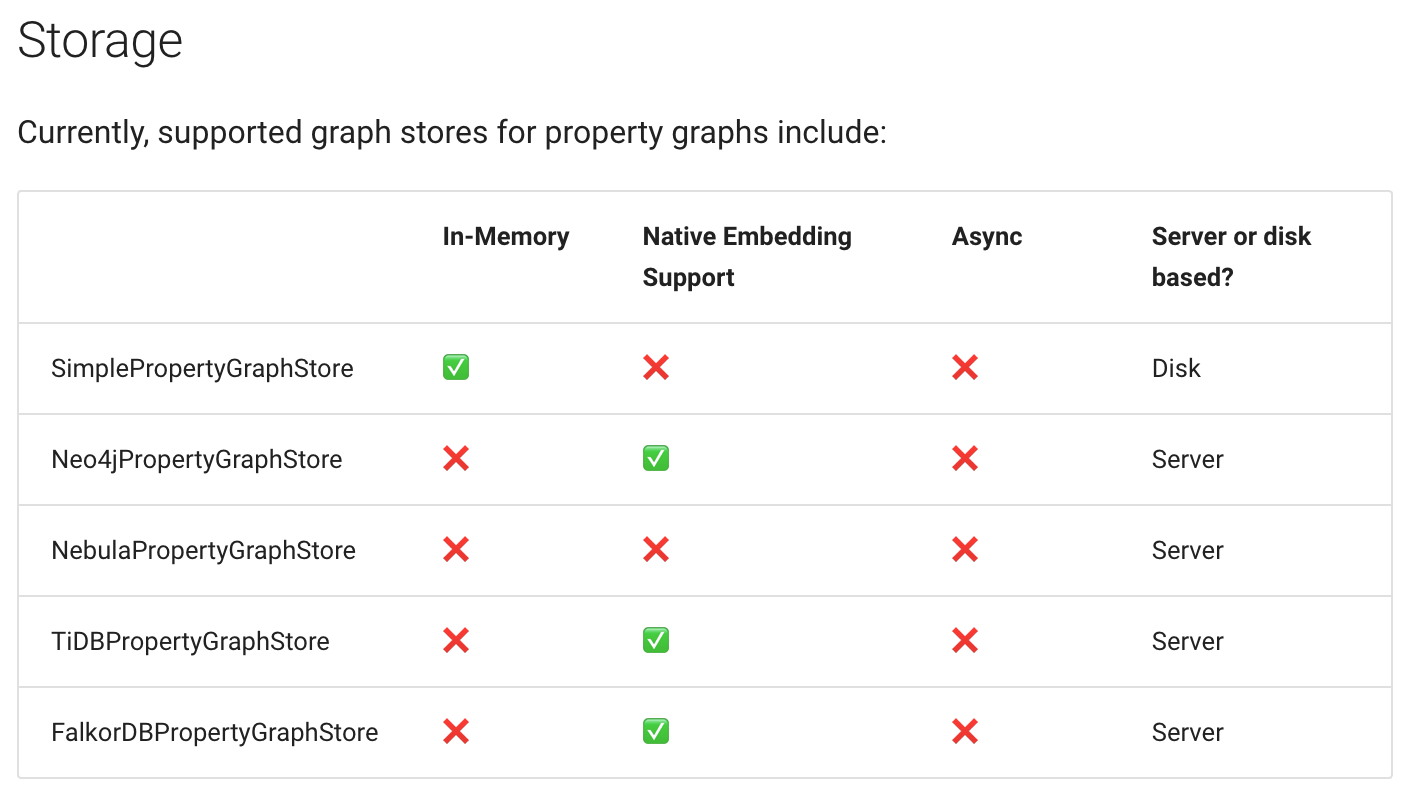